<a href="https://colab.research.google.com/github/panghanwu/tibame_project/blob/main/neo4j_import_database.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install py2neo
import py2neo as neo
import pandas as pd

     |████████████████████████████████| 184kB 2.7MB/s 
     |████████████████████████████████| 348kB 8.2MB/s 
     |████████████████████████████████| 153kB 8.4MB/s 
     |████████████████████████████████| 2.6MB 11.3MB/s 
     |████████████████████████████████| 204kB 24.2MB/s 
  Created wheel for neotime: filename=neotime-1.7.4-cp36-none-any.whl size=20543 sha256=b68c3f973c4273d987b00a673f56a2ab1477c6b05ffe5439b9a83201c00fd032
  Stored in directory: /root/.cache/pip/wheels/d4/b4/c4/ab867cd0ac9e667f8cd269f9364fd1cb8ee75fe50f5ce97c79
Successfully built neotime
ERROR: jupyter-console 5.2.0 has requirement prompt-toolkit<2.0.0,>=1.0.0, but you'll have prompt-toolkit 2.0.10 which is incompatible.
ERROR: ipython 5.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.4, but you'll have prompt-toolkit 2.0.10 which is incompatible.
  Found existing installation: prompt-toolkit 1.0.18
    Uninstalling prompt-toolkit-1.0.18:
      Successfully uninstalled prompt-toolkit-1.0.18


In [2]:
# login info
info = pd.read_csv('login_info.csv', header=None)
sever_link = info[0][0]
pws = info[1][0]

# load data
product_df = pd.read_csv('product_node.csv')
relation_df = pd.read_csv('relationship_matrix.csv', index_col=0)

# data preprocessing
relation_df = relation_df.fillna(.0)  # fill None with .0
relation_df = relation_df + relation_df.T  # diagonal symmetry
psn = relation_df.index  # data list
pn = len(psn)  # data size


In [3]:
"""
Note: this script will overwrite your database.
"""

print('Connecting to the sever...')

# connect to Neo4j database
fashion_map = neo.Graph(sever_link, password=pws)

# clean the database
fashion_map.delete_all()

print('Connected successfully, and cleaned the database.')
print('Creating nodes...')


"""Create node"""
# container of nodes
num  = 5
cate_node = [None]*(num)

# gender
cate_node[0] = neo.Node('Gender', gender='Men', cht='男')
cate_node[1] = neo.Node('Gender', gender='Women', cht='女')

# form
cate_node[2] = neo.Node('Form', form='Full', cht='全身')
cate_node[3] = neo.Node('Form', form='Lower', cht='下著')
cate_node[4] = neo.Node('Form', form='Upper', cht='上衣')

# create
for n in range(num):
	fashion_map.create(cate_node[n])

# import product from csv
pgs = 0
product_node = []
for i in range(pn):
  product_node.append(neo.Node('Product', sn=product_df['sn'][i], 
								       name=product_df['name'][i],
		                   image_url=product_df['image_url'][i],
		                   description=product_df['description'][i]))
  fashion_map.create(product_node[i])
  # progress bar
  pgs += 1
  print('\r' + '[Creating]:[%s%s]%.2f%%' % ('█' * int(pgs*30/pn),
      '  ' * (30-int(pgs*30/pn)),
      float(pgs/pn*100)), end='')

print('\nDone.')

Connecting to the sever...
Connected successfully, and cleaned the database.
Creating nodes...
[Creating]:[██████████████████████████████]100.00%
Done.


In [4]:
"""
Note: node_generator script should be executed first.
"""

print('Connecting to the sever...')

# connect to Neo4j database
fashion_map = neo.Graph(sever_link, password=pws)

# create matcher
matcher = neo.NodeMatcher(fashion_map)

# get product node
product_node = matcher.match('Product')
product_node = list(product_node)
# print(product_node[0]['sn'][0])

print('Creating relationship...')

"""Gender relationship"""

pgs = 0
for i in range(pn):
  if product_node[i]['sn'][0] == 'M':
    target_node = matcher.match('Gender', gender='Men') 
  else:
    target_node = matcher.match('Gender', gender='Women') 

  r = neo.Relationship(product_node[i], 'GENDER', list(target_node)[0])
  fashion_map.merge(r)

  # progress bar
  pgs += 1
  print('\r' + '[GENDER]:[%s%s]%.2f%%' % ('█' * int(pgs*30/pn),
      '  ' * (30-int(pgs*30/pn)),
      float(pgs/pn*100)), end='')
print()

"""Form relationship"""

pgs = 0
for i in range(pn):
  if product_node[i]['sn'][1] == 'F':
    target_node = matcher.match('Form', form='Full') 

  elif product_node[i]['sn'][1] == 'L':
    target_node = matcher.match('Form', form='Lower')

  else:
    target_node = matcher.match('Form', form='Upper') 

  r = neo.Relationship(product_node[i], 'FORM', list(target_node)[0])
  fashion_map.merge(r)
 
  # progress bar
  pgs += 1
  print('\r' + '[FORM]:[%s%s]%.2f%%' % ('█' * int(pgs*30/pn),
      '  ' * (30-int(pgs*30/pn)),
      float(pgs/pn*100)), end='')

print('\nDone.')

Connecting to the sever...
Creating relationship...
[GENDER]:[██████████████████████████████]100.00%
[FORM]:[██████████████████████████████]100.00%
Done.


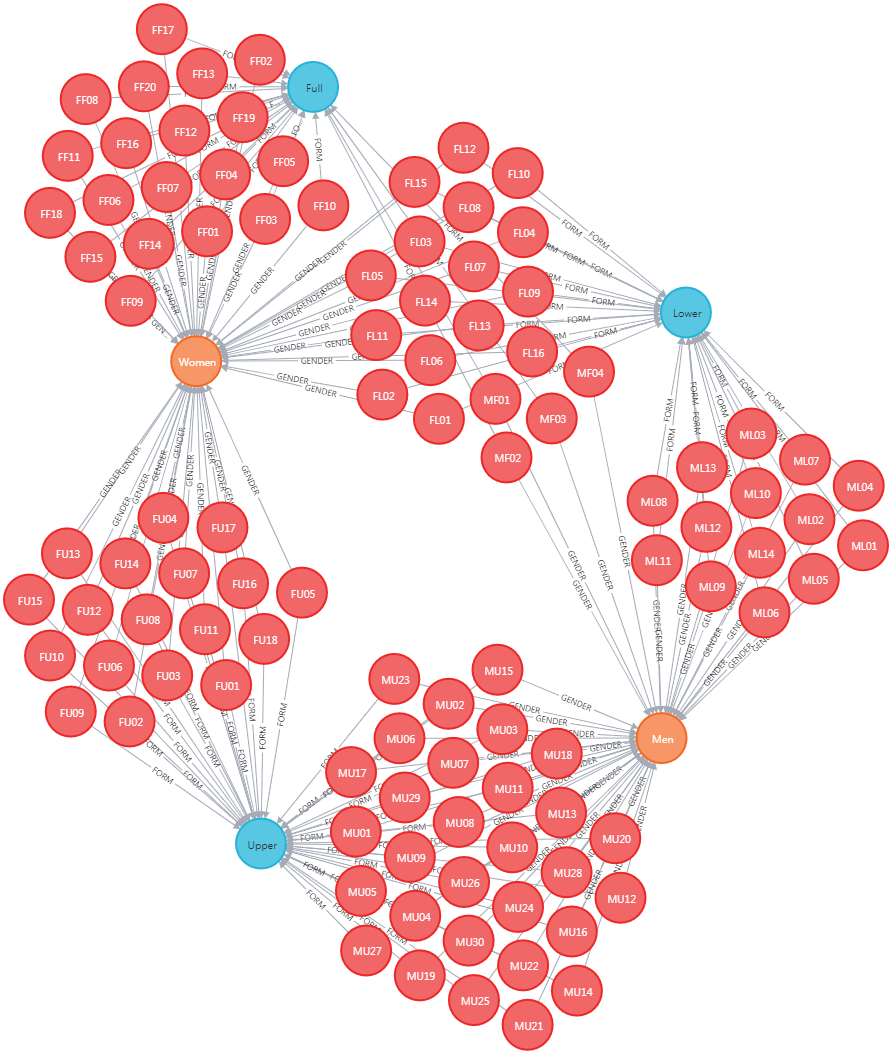

In [5]:
"""Same and fit relationship"""

print('Creating relationship...')
pgs = 0

for i in range(pn):
  for j in range(pn):
    code = relation_df[psn[i]][psn[j]]
    if code == 0.0:
      pass
    elif code == 2:
      r = neo.Relationship(product_node[i], 'SAME', product_node[j])
      fashion_map.merge(r)
    else:
      r = neo.Relationship(product_node[i], 'FIT', product_node[j])
      r['score'] = code
      fashion_map.merge(r)
   
  # progress bar
  pgs += 1
  print('\r' + '[SAME&FIT]:[%s%s]%.2f%%' % ('█' * int(pgs*30/pn),
     '  ' * (30-int(pgs*30/pn)),
     float(pgs/pn*100)), end='')
  
print('\nDone.')

Creating relationship...
[SAME&FIT]:[██████████████████████████████]100.00%
Done.


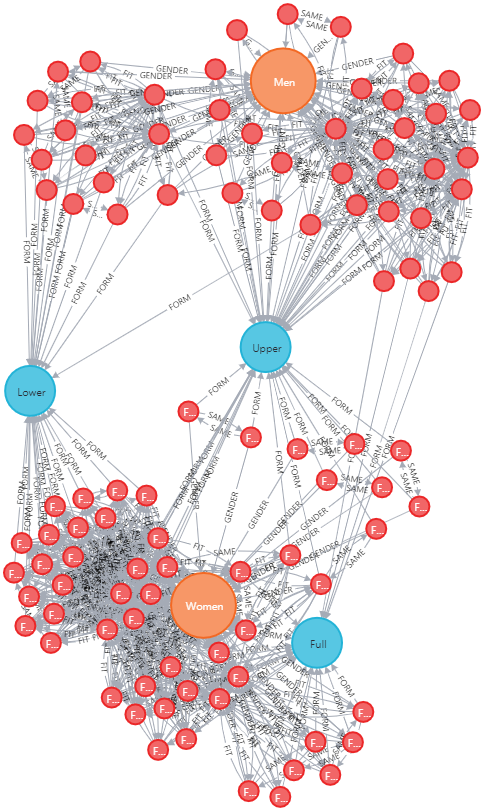